In [9]:
import numpy as np
import warnings
from scipy.stats import norm


class BaseModel:
    
    '''
    Base class for models
    '''
    
    def __init__(self):
        pass
    
    def score(self, Y):
        
        '''
        Returns the log-likelihood of an observation sequence
        '''
        
        score = np.log(self.pdf(Y)).sum()
        return score


class NormalModel(BaseModel):
    
    '''
    i.i.d. normal distribution model
    '''
    
    def __init__(self, mu=0, sigma=1):
        self.mu = mu
        self.sigma = sigma
    
    @property
    def loc(self):
        return self.mu
    
    @property
    def scale(self):
        return self.sigma
    
        
    def fit(self, Y, weights=None):
        
        '''
        Fits the model parameters to an observation sequence.
        weights are optional.
        '''
        
        # prepare
        Y = np.array(Y)
        if weights is None:
            weights = np.ones(Y.shape)
        else:
            weights = np.array(weights)
        
        # estimate mean
        mean = np.average(Y, weights=weights)
        
        # estimate variance
        errors = (Y-mean)**2
        variance = np.average(errors, weights=weights)
        
        # update
        self.mu = mean
        self.sigma = np.sqrt(variance)
        
    def pdf(self, Y):
        
        '''
        Returns the likelihood of each observation in an observation sequence.
        '''
        
        Y = np.array(Y)
        pdf = norm(loc=self.mu, scale=self.sigma).pdf(Y)
        return pdf


In [1213]:
import numpy as np
from scipy.stats import entropy

class MarkovChain:
    
    '''
    A MarkovChain
    '''
    
    def __init__(self, transition_matrix=None, state_vector=None):
        self.transition_matrix = transition_matrix
        self.state_vector = state_vector

    @property
    def transition_matrix(self):
        
        '''
        The Markov state transition probability matrix.
        Needs to be square.
        '''
        
        return self._transition_matrix
        
    @transition_matrix.setter
    def transition_matrix(self, transition_matrix):
        if transition_matrix is not None:        
            transition_matrix = np.array(transition_matrix)
            assert transition_matrix.shape[0] == transition_matrix.shape[1], \
                'transition matrix needs to be square'
            assert all(transition_matrix.sum(axis=1) == 1), \
                'transition matrix rows need to sum to one'
            if hasattr(self, 'state_vector'):
                assert transition_matrix.shape[0] == self.state_vector.shape[1], \
                    'state vector dimension mismatch'
            self._transition_matrix = transition_matrix
        else:
            self._transition_matrix = None
        
    
    @property
    def state_vector(self):
        
        '''
        The current state vector.
        '''
        
        return self._state_vector
    
    @state_vector.setter
    def state_vector(self, state_vector):
        if state_vector is not None:
            state_vector = np.array(state_vector).reshape(1,-1)
            assert state_vector.sum(axis=1) == 1, \
                'state vector needs to sum to one'
            assert (state_vector>=0).all() and (state_vector<=1).all(), \
                'probabilites need to be bounded between zero and one'
            if hasattr(self, 'transition_matrix'):
                assert state_vector.shape[1] == self.transition_matrix.shape[0], \
                    'transition matrix dimension mismatch'
            self._state_vector = state_vector
        else:
            self._state_vector = None
    

    def steady_state(self, set_state=False):
        
        '''
        Returns the steady state probabilities of the Markov chain.
        If set_state=True, MarkovChain object is modified in place.
        '''
        
        dim = np.array(self.transition_matrix).shape[0]
        q = np.c_[(self.transition_matrix-np.eye(dim)),np.ones(dim)]
        QTQ = np.dot(q, q.T)
        steady_state = np.linalg.solve(QTQ,np.ones(dim))
        if set_state:
            self.state_vector = steady_state
        else:
            return steady_state
        
        
    @property
    def expected_durations(self):
        
        '''
        Returns the expected state durations of the MarkovChain object.
        '''
        
        expected_durations = (np.ones(self.n_states)-np.diag(self.transition_matrix))**-1
        return expected_durations
    
    
    @property
    def n_states(self):
        
        '''
        Returns the number of states of the MarkovChain object.
        '''
        
        return self.state_vector.shape[1]


    def iterate(self, steps=1, set_state=False):
        
        '''
        Iterates the MarkovChain object in place.
        steps needs to be a positive integer.
        (negative steps work, but tend to break before the initial state)
        If set_state=True, MarkovChain object is modified in place.
        '''
        
        new_state = np.dot(self.state_vector, np.linalg.matrix_power(self.transition_matrix, steps))
        
        # ensure total probability is 1
        if new_state.sum() != 1:
            new_state = new_state.round(8)/new_state.round(8).sum()
            warnings.warn('Transition matrix rounded to 8 decimal places')
        
        if set_state:
            self.state_vector = new_state
        else:
            return new_state
        
        
    def forecast(self, horizons=[1]):
        
        '''
        Returns forecasted state probabilities for a set of horizons.
        horizons needs to be an iterable.
        '''
        
        horizons_states = np.array([]).reshape(0, self.n_states)
        for horizon in horizons:
            pi_ = np.dot(self.state_vector, np.linalg.matrix_power(self.transition_matrix, horizon))
            horizons_states = np.concatenate([horizons_states, pi_.reshape(1, self.n_states)], axis=0)
        return horizons_states
    

    def rvs(self, t_steps=0, random_state=1):
        
        '''
        Draws a random sample sequence from the MarkovChain object.
        t_steps is the number of time steps forward to be drawn.
        If t_steps is zero, only the current state is drawn.
        '''
        
        sample = np.random.choice(self.n_states, size=1, p=self.state_vector.squeeze())
        for t in range(1, t_steps+1):
            sample = np.concatenate([sample, \
                                     np.random.choice(self.n_states, size=1, p=self.transition_matrix[sample[-1]])])
        return sample
    
    
    def entropy(self, horizons=None):
        
        '''
        Calculate Shannon's entropy of the n state probabilities based on logarithms with base n.
        '''
        
        if horizons is None:
            state_entropy = entropy(self.state_vector.squeeze(), base=self.n_states)
        
        else:
            horizon_states = self.forecast(horizons)
            state_entropy = []
            for horizon in horizon_states:
                state_entropy += [entropy(horizon.squeeze(), base=self.n_states)]
            
        return np.array(state_entropy)
    

In [1214]:
mc = MarkovChain(np.array([[0.99,0.01],[0.2,0.8]]),np.array([0,1]))
mc.iterate(1, set_state=True)
mc.state_vector
mc.transition_matrix
mc.forecast([5,1,7,123,45,0])

array([[0.72086909, 0.27913091],
       [0.358     , 0.642     ],
       [0.8078944 , 0.1921056 ],
       [0.95238095, 0.04761905],
       [0.95236235, 0.04763765],
       [0.2       , 0.8       ]])

In [1215]:
mc.steady_state()

array([0.95238095, 0.04761905])

In [1216]:
mc.entropy()

array(0.72192809)

In [1217]:
mc.rvs(50000).mean()

0.047039059218815626

In [531]:
mc.steady_state(set_state=True)
mc.state_vector

array([[0.95238095, 0.04761905]])

In [554]:
mc.iterate(10, set_state=True)
mc.state_vector

array([[0.95238095, 0.04761905]])

In [567]:
mc=MarkovChain()

In [930]:
import pandas as pd
import numpy as np
import warnings


#from src.dists import GaussianMixtureDistribution
#from src.markov import MarkovChain


class HMM(MarkovChain):
    def __init__(self, emission_models=(), transition_matrix=None, start_probas=None, switch_var=True, switch_const=True, k=None):
        
        '''
        
        '''

        self.emission_models = emission_models
        self.transition_matrix = transition_matrix
        self.start_probas = start_probas
        
        self.switch_var = switch_var
        self.switch_const = switch_const
        self.k = k
        
        self.params_ = None
        self.se_ = None
        self.tstats_ = None

        self.metrics_ = None
        self.smooth_prob_ = None
        self.filt_prob_ = None
    
    


In [983]:
sp.stats.norm(loc=0, scale=1)

## HMM Class 

In [1226]:
class HiddenMarkovModel(MarkovChain):
    
    '''
    Hidden Markov Model class
    '''
    
    def __init__(self, emission_models=None, transition_matrix=None, state_vector=None):#, start_probas=None, switch_var=True, switch_const=True, k=None):
        self.transition_matrix = transition_matrix
        self.state_vector = state_vector
        self.emission_models = emission_models
        self.is_fitted = False
        
        
    @property
    def emission_models(self):
        
        '''
        A tuple of emission models associated with the Markov states.
        '''
        
        return self._emission_models
    
    @emission_models.setter
    def emission_models(self, emission_models):
        if emission_models is not None:
            emission_models = tuple(emission_models)
            if self.transition_matrix is not None:
                assert len(emission_models) == self.transition_matrix.shape[0], \
                    'number of emission models inconsitent'
            elif self.state_vector is not None:
                assert len(emission_models) == self.state_vector.shape[1], \
                    'number of emission models inconsitent'
            self._emission_models = emission_models
            
        else:
            self._emission_models = None
    
    
    
    def fit(self, Y, method):
        self.is_fitted = True
    
    
    def _estimate_baum_welch(self, Y, max_iter=100, threshold=1e-6, return_fit=False):
        
        '''
        Performs parameter estimation with the Baum-Welch algorithm.
        Returns a fitted model.
        Returns the the fitted model and parameters of the estimation if return_fit=True.
        '''
        
        # initialise
        Y = np.array(Y)
        A_, pi_, models_ = self._initialise_baum_welch()
        self._check_baum_welch_inputs(A_, pi_, models_)
        score_, B_ = self._score(Y, models_, pi_)
        
        # store
        iteration = 0
        scores = {iteration: score_}
        
        while iteration < max_iter:
            iteration += 1
            Alpha, Gamma, Xi = self._do_e_step(Y, A_, B_, pi_)          
            A_, models_, pi_ = self._do_m_step(Y, models_, Gamma, Xi)
            score_, B_ = self._score(Y, models_, Gamma)
            scores[iteration] = score_
            
            if abs(scores[iteration]-scores[iteration-1]) < threshold:
                converged = True
                break
        else:
            converged = False
            warnings.warn('maximum number of iterations reached')
                
        self._update_attributes(A_, models_, pi_)
        
        if return_fit:
            fit = {'converged': converged,
                   'iterations': iteration,
                   'scores': scores,
                   'pdfs': B_,
                   'smoothened_probabilities': Gamma,
                   'filtered_probabilities': Alpha}
            
            return self, fit
        else:
            return self
    
    
    def _initialise_baum_welch(self):
        
        '''
        Returns initial values for the Baum-Welch algorithm.
        '''
        
        assert self.emission_models is not None, \
            'emission models not specified'
            
        if self.state_vector is None:
            self.steady_state(set_state=True)
        if self.transition_matrix is None:
            self.transition_matrix = np.full([self.n_states, self.n_states], 1/self.n_states)
        
        A = self.transition_matrix
        models = self.emission_models
        pi = self.state_vector
        return A, pi, models
    
    
    def _check_baum_welch_inputs(self, A, pi, models):
        
        '''
        Checks the dimension match of algorithm inputs.
        '''

        assert len(models) == A.shape[0] == A.shape[1] == pi.shape[1], \
            'dimension mismatch'
    
    
    def _score(self, Y, emission_models, Gamma):
        
        '''
        Returns the overall model score and component model pdf values for each observation.
        '''
        
        B = self._evaluate_emission_models(Y, emission_models)
        score = np.log((B * Gamma).sum(axis=1)).sum(axis=0)
        return score, B
    
    
    def _evaluate_emission_models(self, Y, emission_models):
        
        '''
        Returns component model pdf values for each observation.
        '''
        
        B = np.concatenate([model.pdf(Y).reshape(-1, 1) for model in emission_models], axis=1)
        return B
    
    
    def _do_e_step(self, Y, A, B, pi):
        
        '''
        Performs all steps of the E-step and returns temporary variables.
        All data state probabilities are updated based on the existing component models.
        '''
        
        Alpha, C = self._forward_pass(A, B, pi)
        Beta = self._backward_pass(A, B, pi, C)
        Gamma = self._emission_odds(Alpha, Beta)
        Xi = self._transition_odds(A, B, Alpha, Beta)
        return Alpha, Gamma, Xi
    
    
    def _forward_pass(self, A, B, pi):
        
        '''
        Returns filtered probabilities of the data together with each scaling factor.
        '''
        
        # initialise forward pass with first observation
        alpha_0 = pi * B[0]
        c_0 = 1/alpha_0.sum()
        
        # save values & scaling factor
        Alpha = alpha_0*c_0
        C = [c_0]
        
        # iterate
        for b_t in B[1:]:
            # calculate
            alpha_t = (b_t * Alpha[-1] @ A).reshape(1, -1)
            c_t = 1/alpha_t.sum()
            
            # save
            Alpha = np.concatenate((Alpha, alpha_t*c_t), axis=0)
            C += [c_t]
            
        C = np.array(C).reshape(-1, 1)
        return Alpha, C

    
    def _backward_pass(self, A, B, pi, C):
        
        '''
        Returns smoothened probabilities of the data.
        '''
        
        # initialise backward pass as one
        beta_T = np.ones(pi.shape)
        
        # save values & scaling factor
        Beta = beta_T*C[-1]
        
        # iterate
        for b_t, c_t in zip(B[:0:-1],C[len(C)-2::-1]):
            # calculate
            beta_t = (b_t * Beta[0] @ A.T).reshape(1, -1)
            
            # save
            Beta = np.concatenate((beta_t*c_t, Beta), axis=0)
            
        return Beta
    
    
    def _emission_odds(self, Alpha, Beta):
        
        '''
        Returns odds for each observation to be emitted by each component model.
        '''
        
        total = Alpha * Beta
        Gamma = total/total.sum(axis=1).reshape(-1, 1)
        return Gamma
    
    
    def _transition_odds(self, A, B, Alpha, Beta):
        
        '''
        Returns the odds of each state to transition from each state to each state.
        '''
        
        Alpha_block = np.kron(Alpha[:-1], np.ones(A.shape[0]))
        B_Beta_block = np.kron(np.ones(A.shape[0]), B[1:]*Beta[1:])
        total = Alpha_block * B_Beta_block * A.reshape(1, -1)
        Xi = total/total.sum(axis=1).reshape(-1, 1)
        return Xi
    
    
    def _do_m_step(self, Y, models, Gamma, Xi):
        
        '''
        Performs all steps of the M-step and returns temporary variables.
        All component models are reestimated and parameters updated.
        '''
        
        A_ = self._update_transition_matrix(Gamma, Xi)
        models_ = self._update_model_parameters(Y, models, Gamma)
        pi_ = self._update_initial_state(Gamma)
        return A_, models_, pi_
    

    def _update_transition_matrix(self, Gamma, Xi):
        
        '''
        Returns an updated Markov transition matrix.
        '''
        
        numerator = Xi.sum(axis=0)
        denominator = np.kron(Gamma[:-1], np.ones(Gamma.shape[1])).sum(axis=0)
        A_ = (numerator/denominator).reshape(Gamma.shape[1], Gamma.shape[1])
        return A_
    
    
    def _update_model_parameters(self, Y, emission_models, Gamma):
        
        '''
        Returns updated emission models.
        '''
        
        models_ = []
        for model, weights in zip(emission_models, Gamma.T):
            model.fit(Y, weights)
            models_ += [model]
        return tuple(models_)
    
    
    def _update_initial_state(self, Gamma):
        
        '''
        Returns updated initial state probabilities.
        '''
        
        return Gamma[0].reshape(1, -1)
    
    
    def _update_attributes(self, A_, models_, pi_):
        
        '''
        Updates the HMM attributes in place.
        '''
        
        # ensure total transition probabilities are 1
        if (A_.sum(axis=1) != 1).any():
            A_ = A_.round(6)/A_.round(6).sum(axis=1)
            warnings.warn('Transition matrix rounded to 6 decimal places')
        self.transition_matrix = A_
        
        self.emission_models = models_
        
        state_vector = Alpha[-1]
        # ensure total state probability is 1
        if state_vector.sum() != 1:
            state_vector = state_vector.round(8)/state_vector.round(8).sum()
            warnings.warn('State vector rounded to 8 decimal places')
        self.state_vector = state_vector
    

    def mixture_distribution(self, steady_state=False):
        if steady_state:
            probas = self.steady_state().squeeze()
        else:
            probas = self.state_vector.squeeze()

        components = [(self.emission_models[i].mu, self.emission_models[i].sigma, probas[i]) for i in range(self.n_states)]
        mix = GaussianMixtureDistribution(components=components)
        return mix
    

In [ ]:
    def fit(self, y, package='baumwelch', start_params=None, iter=100, **kwargs):
        
        '''
        Fits the Gaussian HMM to the series y.
        '''
        
        assert package in ['statsmodels', 'hmmlearn', 'baumwelch'], 'package unknown'
        
        if package == 'statsmodels':            
            from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
            
            #if start_params is None:
                #start_params = np.random.randn(self.k+self.k**2)*0.01
                #m = y.mean()
                #s = y.std()
                #v = y.var()
                #start_params = np.full(self.**2-self.k, 1/self.k).tolist()\
                #                        +(np.random.randn(self.k)*s/2+m).tolist()\
                #                        +(np.random.randn(self.k)*v+s).tolist()
            model = MarkovRegression(endog=y, switching_variance=self.switch_var, switching_trend=self.switch_const, k_regimes=self.k)\
                                .fit(start_params=start_params, maxiter=iter, **kwargs)
            self.params_ = model.params
            self.se_ = model.bse
            self.tstats_ = model.tvalues
            self.metrics_ = pd.Series({'llf': model.llf, 'aic': model.aic, 'bic': model.bic,})
            self.smooth_prob_ = model.smoothed_marginal_probabilities
            self.filt_prob_ = model.filtered_marginal_probabilities
        
        if package == 'hmmlearn':
            from hmmlearn.hmm import GaussianHMM
            
            assert self.switch_var is True and self.switch_const is True, 'only implemented for fully parametrised components'
            t_index = y.index
            y = np.expand_dims(y.values, axis=1)
            model = GaussianHMM(n_components=self.k, n_iter=iter, **kwargs).fit(y)
            trans_probas = model.transmat_.T.reshape(self.k**2,1)[:self.k**2-self.k]
            states = np.arange(self.k)
            p_index=[f'p[{j}->{i}]' for i in states[:-1] for j in states]\
                        +[f'const[{i}]' for i in states]\
                        +[f'sigma2[{i}]' for i in states]
            self.params_ = pd.Series(np.concatenate((trans_probas, model.means_, model.covars_.squeeze(axis=1))).squeeze(), index=p_index)
            llf = model.score(y)
            self.metrics_ = pd.Series({'llf': llf,
                                       'aic': 2*len(self.params_)-2*llf,
                                       'bic': len(self.params_)*np.log(len(y))-2*llf})
            self.smooth_prob_ = pd.DataFrame(model.predict_proba(y), index=t_index)

        if package == 'baumwelch':
            self = self._estimate_baum_welch(np.array(y), max_iter=iter, **kwargs)

        return self
    
    
    @property
    def estimates_(self):
        estimates = pd.DataFrame({'estimate': self.params_,
                                  's.e.': self.se_,
                                  't-stat': self.tstats_})
        return estimates
    

    @property
    def transition_matrix_(self):
        k = self.k
        trans_matrix = np.matrix(self.params_[:k**2-k].values.reshape(k-1, k).T)
        trans_matrix = np.append(trans_matrix, 1-trans_matrix.sum(axis=1), axis=1)
        return trans_matrix



    def get_mixture_distribution(self, state='steady_state'):
        if state == 'steady_state':
            probas = self.steady_state_
        elif state == 'latest':
            probas = self.filt_prob_.iloc[-1]
        else:
            assert len(state) == self.k, 'wrong number of state probabilities'
            probas = state

        components = [(self.params_[f'const[{i}]'], self.params_[f'sigma2[{i}]']**0.5, probas[i]) for i in range(self.k)]
        mix = GaussianMixtureDistribution(components=components)
        return mix


    def filtered_moments(self):
        filt_mom = pd.DataFrame(index=self.filt_prob_.index, columns=['mean','var','skew','kurt','entropy'])
        for date, probas in self.filt_prob_.iterrows():
            mix = self.get_mixture_distribution(state=probas.values)
            filt_mom.loc[date] = [*mix.mvsk(), mix.entropy()]

        return filt_mom


    def smoothened_moments(self):
        smooth_mom = pd.DataFrame(index=self.smooth_prob_.index, columns=['mean','var','skew','kurt','entropy'])
        for date, probas in self.smooth_prob_.iterrows():
            mix = self.get_mixture_distribution(state=probas.values)
            smooth_mom.loc[date] = [*mix.mvsk(), mix.entropy()]
        return smooth_mom
        

    # def fit(self, Y, method='baumwelch', **kwargs):
    #     '''OK'''
    #     assert method in ['baumwelch'], 'method unknown'
        
    #     if method == 'baumwelch':
    #         self = self._estimate_baum_welch(Y, **kwargs)

In [1219]:
nm = norm(0,2)
nm.rvs(1000).std()

2.02524412017951

In [1147]:
NormalModel(2,3).score([0,1,4])

-6.552652465618347

In [1163]:
from scipy.stats import norm

nm = norm(0,2)
x = nm.rvs(100)
norm.fit(x)
#nm.cdf(2)

(-0.08926836706609464, 1.8886346584061724)

In [1227]:
model = NormalModel().fit(x)
model.mu

AttributeError: 'NoneType' object has no attribute 'mu'

In [1195]:
x = list(norm(1,2).rvs(100))
weights = list(norm(1,1).rvs(100))
model = NormalModel()
model.fit(Y=x, weights=None)
print(model.mu,model.sigma)



1.4312078025019093 1.9338967679062828


In [1228]:
mdls = (NormalModel(0,1), NormalModel(1,1))
hmm = HiddenMarkovModel(transition_matrix=np.array([[0.99,0.01],[0.2,0.8]]), state_vector=[0,1], emission_models=mdls)
hmm.mixture_distribution()

NameError: name 'GaussianMixtureDistribution' is not defined

In [1197]:
Y = sp.stats.norm(0.5,2).rvs(100)
print(hmm.emission_models[0].mu, hmm.emission_models[1].mu)
print(hmm.emission_models[0].sigma, hmm.emission_models[1].sigma)
hmm._estimate_baum_welch(Y, max_iter=100, return_fit=True)

0 1
1 1


/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/ipykernel_launcher.py:74: UserWarning: maximum number of iterations reached
/home/rubelrennfix/.virtualenvs/hmmdalah/lib/python3.6/site-packages/ipykernel_launcher.py:287: UserWarning: Transition matrix rounded to 6 decimal places


(<__main__.HiddenMarkovModel at 0x7fb73c8d3ac8>,
 {'converged': False,
  'iterations': 100,
  'scores': {0: -302.08155430046463,
   1: -203.2164848064916,
   2: -207.89994049453713,
   3: -208.97968628014382,
   4: -209.19713102433198,
   5: -209.23331877811015,
   6: -209.23457008846913,
   7: -209.23121522930748,
   8: -209.2285804614822,
   9: -209.22701861744315,
   10: -209.22615943925453,
   11: -209.22568898664704,
   12: -209.22542053351563,
   13: -209.22525418059695,
   14: -209.22513871976065,
   15: -209.22504840047964,
   16: -209.22497038929177,
   17: -209.22489831723425,
   18: -209.22482902967454,
   19: -209.22476096535044,
   20: -209.22469335173074,
   21: -209.22462580647445,
   22: -209.22455814022982,
   23: -209.22449025909884,
   24: -209.22442211640143,
   25: -209.2243536888217,
   26: -209.2242849646098,
   27: -209.2242159377466,
   28: -209.22414660505677,
   29: -209.2240769647806,
   30: -209.22400701586776,
   31: -209.22393675762746,
   32: -209.223866

In [ ]:
HiddenMarkovModel?

In [1198]:
(hmm.emission_models[0].mu, hmm.emission_models[1].mu)

(0.41717558561371837, 0.367721703537283)

In [989]:
hmm.state_vector

array([[9.99223779e-01, 7.76220953e-04]])

In [990]:
hmm.initial_probabilities_

AttributeError: 'HiddenMarkovModel' object has no attribute 'initial_probabilities_'

In [991]:
hmm.smooth_prob_#.shape

array([[0.00000000e+00, 1.00000000e+00],
       [9.88632376e-02, 9.01136762e-01],
       [2.19245447e-01, 7.80754553e-01],
       [2.80173760e-01, 7.19826240e-01],
       [3.20463481e-01, 6.79536519e-01],
       [3.65049874e-01, 6.34950126e-01],
       [4.12885723e-01, 5.87114277e-01],
       [4.68635404e-01, 5.31364596e-01],
       [5.37911219e-01, 4.62088781e-01],
       [6.22013787e-01, 3.77986213e-01],
       [7.00573227e-01, 2.99426773e-01],
       [7.48521720e-01, 2.51478280e-01],
       [7.83495244e-01, 2.16504756e-01],
       [8.07459801e-01, 1.92540199e-01],
       [8.36676243e-01, 1.63323757e-01],
       [8.66904725e-01, 1.33095275e-01],
       [8.87224591e-01, 1.12775409e-01],
       [9.06720724e-01, 9.32792763e-02],
       [9.18452392e-01, 8.15476076e-02],
       [9.31113145e-01, 6.88868555e-02],
       [9.44337273e-01, 5.56627270e-02],
       [9.52654525e-01, 4.73454745e-02],
       [9.57795749e-01, 4.22042512e-02],
       [9.61588112e-01, 3.84118883e-02],
       [9.662484

In [69]:
class BaseDistribution:
    
    '''
    Base class for distributions.
    '''
    
    def __init__(self):
        pass
    

    def std(self):

        '''
        Returns the distribution standard deviation.
        '''

        return self.var()**0.5


    def exkurt(self):

        '''
        Returns the excess kurtosis.
        '''

        return self.kurt()-3


    def mvsk(self):
    
        '''
        Returns the first four standardised moments about the mean.
        '''
    
        m = self.mean()
        v = self.var()
        s = self.skew()
        k = self.kurt()
        return (m, v, s, k)


class GaussianMixtureDistribution(BaseDistribution):
    
    '''
    A GaussianMixtureDistribution is a list of triples that parametrise the components of a Gaussian mixture distribution.
    Each triple is a tuple of mean, standard deviation and probability weight of the component.
    '''
    
    def __init__(self, components=[]):
        self.components = components
        self.n_components = len(self.components)
        
    def add_component(self,component):
        self.components += [component]
        self.n_components += 1
        
    def central_moment(self, moment):

        '''
        Compute the central moments of a mixture of normal components.
        Moment is the order of the central moment to compute.
        '''

        mean = sum([w*m for (m, s, w) in self.components])
    
        if moment is 1:
            return mean
        else:
            mixture_moment = 0
            for (m, s, w) in self.components:
                for k in range(moment+1):
                    product = sp.special.comb(moment, k) * (m-mean)**(moment-k) * normal_central_moment(s, k)
                    mixture_moment += w * product
            return mixture_moment
        
    def standardised_moment(self, moment):
    
        '''
        Normalised moment of a mixture distribution.
        '''
    
        if (moment<=2):
            mixture_moment = self.central_moment(moment)
        else:
            mixture_variance = self.central_moment(2)
            mixture_central_moment = self.central_moment(moment)
            mixture_moment = mixture_central_moment / mixture_variance**(moment/2)
            if (moment%2==0):
                bias = normal_central_moment(1,moment)
                mixture_moment -= bias
        return mixture_moment
    

    def mean(self):
        return self.standardised_moment(1)
    

    def var(self):
        return self.standardised_moment(2)
    

    def std(self):
        return self.standardised_moment(2)**0.5
    

    def skew(self):
        return self.standardised_moment(3)
    

    def kurt(self):
        
        '''
        Note that the output value is the excess kurtosis.
        '''
        
        return self.standardised_moment(4)
    

    # def mvsk(self):
    
    #     '''
    #     The first four standardised moments about the mean of a mixture distribution.
    #     '''
    
    #     m = self.mean()
    #     v = self.var()
    #     s = self.skew()
    #     k = self.kurt()
    #     return (m,v,s,k)

            
    def rvs(self, sample_size=1):
    
        '''
        Draw a random sample from a mixture distribution
        '''
    
        weights = [p for (m,s,p) in self.components]
        norm_params = [(m,s) for (m,s,p) in self.components]
        draw_from = np.random.choice(self.n_components, size=sample_size, replace=True, p=weights)
        sample = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in draw_from),dtype=np.float64)
        if sample_size is 1:
            sample = sample[0]
        return sample
    

    def pdf(self, x):
        y = np.zeros(np.array(x).shape)
        for (m, s, w) in self.components:
            y += w*sp.stats.norm.pdf(x, m, s)
        return y
    

    def cdf(self, x):
        y = np.zeros(np.array(x).shape)
        for (m, s, w) in self.components:
            y += w*sp.stats.norm.cdf(x, m, s)
        return y
    

    def entropy(self):
        
        '''
        Calculate Shannon's entropy based on logarithms with base n of the n component probabilities.
        '''
        
        entropy = 0
        for (m, s, w) in self.components:
            if w == 0:
                pass
            else:
                entropy += w*np.log(w)/np.log(self.n_components)
        return abs(entropy)
    
    def get_component_means(self):
        means = [m for (m,s,w) in self.components]
        return means
    
    def get_component_stds(self):
        stds = [s for (m,s,w) in self.components]
        return stds
    
    def get_component_weights(self):
        weights = [w for (m,s,w) in self.components]
        return weights

In [184]:
import scipy as sp
_ = GaussianMixtureDistribution([(1,2,0.5),(0,1,0.5)])
_.mvsk()

NameError: name 'normal_central_moment' is not defined

In [429]:
class NormalDistribution(BaseDistribution):
    
    '''
    A normal distribution.
    If no parameters are specified, a standard normal distribution.
    '''
    
    def __init__(self, mu=0, sigma=1):
        self.mu = mu
        self.sigma = sigma
        
        
    @property
    def mu(self):
        
        '''
        The distribution mean.
        '''
        
        return self._mu
    
    @mu.setter
    def mu(self, mu):
        assert type(mu) == int or type(mu) == float, \
            'mu needs to be numeric'
        self._mu = mu
        
        
    @property
    def sigma(self):
        
        '''
        The distribution standard deviation.
        '''
        
        return self._sigma
    
    @sigma.setter
    def sigma(self, sigma):
        assert type(sigma) == int or type(sigma) == float, \
            'sigma needs to be numeric'
        self._sigma = sigma
    
    
    def central_moment(self, moment):

        '''
        Returns the central moments of input order.
        '''
        
        assert moment>0 and type(moment)==int, \
            'moment needs to be a positive integer'

        if moment % 2 == 1:
            #odd moments of a normal are zero
            central_moment = 0 
        else:
            #even moments are given by sigma^n times the double factorial
            central_moment = self.sigma**moment * sp.special.factorialk(moment-1, 2)
        return central_moment
    
    
    def standardised_moment(self, moment):
    
        '''
        Returns the normalised moment of input order.
        '''
        
        assert moment>0 and type(moment)==int, \
            'moment needs to be a positive integer'
        
        central_moment = self.central_moment(moment)
        if (moment<=2):
            standardised_moment = central_moment
        else:
            standardised_moment = central_moment / self.var()**(moment/2)
        return standardised_moment
    
    
    def mean(self):
        
        '''
        Returns the distribution mean.
        '''
        
        return self.mu
    
    
    def var(self):
        
        '''
        Returns the distribution variance.
        '''
        
        var = self.standardised_moment(2)
        return var
    
    
    def skew(self):
        
        '''
        Returns the distribution skewness.
        '''
        
        skew = self.standardised_moment(3)
        return skew
    
    
    def kurt(self):
        
        '''
        Returns the distribution kurtosis.
        '''
        
        kurt = self.standardised_moment(4)
        return kurt
    
    
    def pdf(self, x):
        y = sp.stats.norm(loc=self.mu, scale=self.sigma).pdf(x)
        return y
    
    
    def cdf(self, x):
        y = sp.stats.norm(loc=self.mu, scale=self.sigma).cdf(x)
        return y
    
    
    def rvs(self, size=1):
        sample = sp.stats.norm(loc=self.mu, scale=self.sigma).rvs(size=size)
        return sample

In [457]:
class MixtureDistribution(BaseDistribution):
    
    '''
    A mixture distribution is a list of triples that parametrise the components of a Gaussian mixture distribution.
    Each triple is a tuple of mean, standard deviation and probability weight of the component.
    '''
    
    def __init__(self, components=None):
        self.components = components
        
    
    def _check_component(self, component):
        dist, weight = component
        assert isinstance(dist, BaseDistribution), \
            'unknown component distribution type'
        assert type(weight) == float or type(weight) == int, \
            'weight needs to be numberic'
    
    @property
    def components(self):
        
        '''
        
        '''
        
        return self._components
    
    @components.setter
    def components(self, components):
        assert type(components) == list, \
            'components needs to be a list of tuples'
        for component in components:
            self._check_component(component)
        self._components = components
        
        
    @property
    def distributions(self):
        
        '''
        Returns a list of component distributions.
        '''
        
        distributions = [component[0] for component in self.components]
        return distributions
        
        
    @property
    def weights(self):
        
        '''
        Returns a list of component weights.
        '''
        
        weights = [component[1] for component in self.components]
        return weights
    
    
    @property
    def n_components(self):
        
        '''
        Returns the number of components.
        '''
        
        return len(self.components)
    
    
    def add_component(self, distribution, weight):
        
        '''
        Adds a component to the mixture distribution.
        Inputs needs to be a distribution and a weight.
        '''
        
        component = (distribution, weight)
        self._check_component(component)
        self.components = self.components + [component]

        
    def mean(self):
        
        '''
        Returns the mean.
        '''
        
        mean = sum([component.mean()*weight for (component, weight) in self.components])
        return mean
        
    
    def central_moment(self, moment):

        '''
        Returns the central moment of input order.
        '''

        assert moment > 0, \
            'moment needs to be positive'
    
        if moment is 1:
            return 0
        else:
            mean = self.mean()
            inputs = [(component.mean(), component.std(), weight) for (component, weight) in self.components]
            central_moment = 0
            for (m, s, w) in inputs:
                for k in range(moment+1):
                    product = sp.special.comb(moment, k) * (m-mean)**(moment-k) * sp.stats.norm(loc=0, scale=s).moment(k)
                    central_moment += w * product
            return central_moment
        
        
    def standardised_moment(self, moment):
    
        '''
        Returns the normalised moment of input order.
        '''
    
        if (moment<=2):
            standardised_moment = self.central_moment(moment)
        else:
            variance = self.central_moment(2)
            central_moment = self.central_moment(moment)
            standardised_moment = central_moment / variance**(moment/2)
            if (moment%2==0):
                bias = sp.stats.norm(loc=0, scale=1).moment(moment)
                standardised_moment -= bias
        return standardised_moment
    

    def var(self):
        
        '''
        Returns the distribution variance.
        '''
        
        return self.standardised_moment(2)
    

    def skew(self):
        
        '''
        Returns the distribution skewness.
        '''
        
        return self.standardised_moment(3)
    

    def kurt(self):
        
        '''
        Returns the distribution kurtosis.
        '''
        
        return self.standardised_moment(4)
    
    
    def entropy(self, level='state'):
        
        '''
        Returns Shannon's entropy based on logarithms with base n of the n component probabilities.
        '''
        
        if level == 'state':
            entropy = sp.stats.entropy(mix.weights, base=mix.n_components)
        else:
            raise NotImplementedError('random variable entropy not implemented')
        return entropy
    
    
    def component_means(self):
        
        '''
        Returns a list of component means.
        '''
        
        means = [distribution.mean() for (distribution, weight) in self.components]
        return means
    
    
    def component_stds(self):
        
        '''
        Returns a list of component standard deviations.
        '''
        
        stds = [distribution.std() for (distribution, weight) in self.components]
        return stds
    

    def pdf2(self, x):
        
        '''
        
        '''
        
        y = np.zeros(np.array(x).shape)
        for (m, s, w) in self.components:
            y += w*sp.stats.norm.pdf(x, m, s)
        return y
    
    
    def pdf(self, x):
        
        '''
        Evaluates the probability density function at x.
        '''
        
        y = np.zeros(np.array(x).shape)
        for (component, weight) in self.components:
            y += weight*component.pdf(x)
        return y
    
    
    def cdf(self, x):
        
        '''
        Evaluates the cumulative density function at x.
        '''
        
        y = np.zeros(np.array(x).shape)
        for (component, weight) in self.components:
            y += weight*component.cdf(x)
        return y


    def rvs(self, size=1, return_states=False):
    
        '''
        Draw a random sample from a mixture distribution
        '''
    
        states = np.random.choice(self.n_components, size=size, replace=True, p=self.weights)
        sample = np.fromiter((self.components[i][0].rvs() for i in states), dtype=np.float64)
        
        if size is 1:
            sample = sample[0]
            
        if return_states:
            return (sample, states)
        else:
            return sample
    


In [459]:
comp1 = NormalDistribution(0,1)
comp2 = NormalDistribution(1,2)
comp3 = NormalDistribution(0.5,4)

In [460]:
comps = [(comp1, 0.5), (comp2, 0.5)]
mix = MixtureDistribution(comps)
mix.n_components

2

<AxesSubplot:>

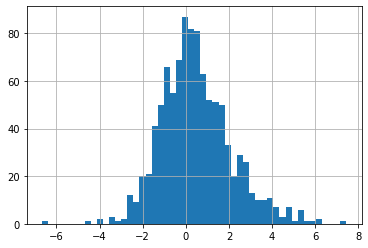

In [454]:
pd.Series(mix.rvs(1000)).hist(bins=50)

In [455]:
mix.component_means()

[0, 1]

<AxesSubplot:>

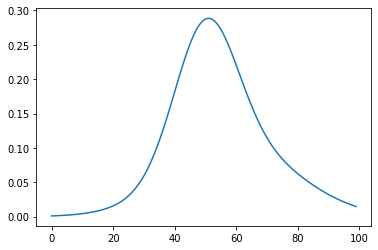

In [456]:
import pandas as pd
pd.Series(mix.pdf(np.arange(-5,5,0.1))).plot()

In [387]:
mix.pdf([2,5,1,9])

array([1.15011815e-01, 1.34984850e-02, 2.20720932e-01, 3.34575564e-05])

In [375]:
mix.var()
mix.skew()
mix.kurt()
mix.exkurt()
mix.mvsk()

(0.5, 2.75, 0.49338220021815865, 0.8760330578512399)

In [371]:
mix.entropy()

1.0

In [364]:
sp.stats.entropy(mix.weights, base=mix.n_components)

0.0